# Tokenizer Dataset sampling

In [1]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ["OMP_NUM_THREADS"] = '4'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTEN
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE

## Functions defining

In [4]:
def get_IR(target) -> float:  # imbalance ratio
    major_class: int = max(target.value_counts())
    minor_class: int = min(target.value_counts())
    IR: float = minor_class / major_class
    return IR    

In [5]:
def plot_classified_values(target, data) -> None:
    sns.countplot(x=target, data=data)
    plt.title("Number of classified values")
    plt.show()

In [6]:
def plot_2d(ax, X, Y, reduction_transformer, n_components=None, title: str = "", annotate: bool = False):
    clear_index = []
    for i in range(len(Y)):
        if Y.iloc[i] == 0:
            clear_index.append(i)
    obf_index = list(set(np.arange(0, len(X)))-set(clear_index))

    embedding = []
    if n_components:
        tranformer_embedding = reduction_transformer(n_components=n_components, random_state=42).fit_transform(X)

        tsne_object = TSNE(n_components=2, verbose=0, random_state=42)
        embedding = tsne_object.fit_transform(tranformer_embedding)
    else:
        embedding = reduction_transformer(n_components=2, random_state=42).fit_transform(X)

    x_clear = embedding[clear_index, 0]
    y_clear = embedding[clear_index, 1]
    ax.scatter(x_clear, y_clear, color='green')

    x = embedding[obf_index,0]
    y = embedding[obf_index,1]
    ax.scatter(x, y, color='red')

    if annotate:
        for i, index in enumerate(clear_index):
            ax.annotate(index, xy=(x_clear[i], y_clear[i]))
    ax.set_title(title)
    return ax

In [7]:
def scale_data(scaler, X):
    scaler = scaler.fit(X)
    X_scale = scaler.transform(X)
    return scaler, X_scale

In [8]:
def show_imbalanced_2d_plot(imbalance_obj, X, Y, reduction_transformer, n_components=None):
    X_resampled, y_resampled = imbalance_obj.fit_resample(X, Y)
    print("Default data's resample was completed successfully!")
    
    scaler_minmax = MinMaxScaler()
    scaler_minmax, X_scaled_minmax = scale_data(scaler_minmax, X)
    X_resampled_minmax, y_resampled_minmax = imbalance_obj.fit_resample(X_scaled_minmax, Y)
    print("MinMax scaled data's resample was completed successfully!")
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    plot_2d(ax=ax1,
            X=X_scaled_minmax, 
            Y=Y, 
            n_components=n_components,
            reduction_transformer=reduction_transformer,
            title=f'MinMax нормировка БЕЗ сэмплирования\n {n_components} компонент')
    plot_2d(ax=ax2, 
            X=X_resampled_minmax, 
            Y=y_resampled_minmax, 
            n_components=n_components, 
            reduction_transformer=reduction_transformer,
            title=f'MinMax нормировка {imbalance_obj} \n {n_components} компонент')

    return imbalance_obj, X_resampled, y_resampled, X_resampled_minmax, y_resampled_minmax

## Data uploading

In [9]:
UPDATED_DATASET_PATH: str = r"D:\Obfuscation\data\datasets\TOKENIZER_DATASET_UPDATED.csv"
df = pd.read_csv(UPDATED_DATASET_PATH, sep=';')
X, y = df.iloc[:, :-1], df.iloc[:, -1]

## Target value analyse

In [10]:
print(get_IR(y))

0.05876068376068376


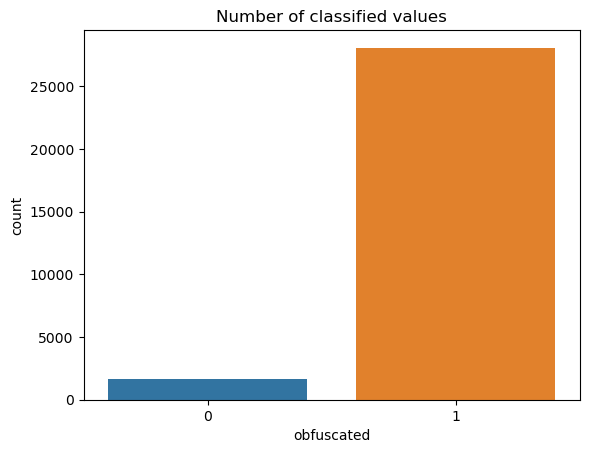

In [9]:
plot_classified_values(y, df)

## Undersampling and oversampling processing over all dataset

In [6]:
undersample_list = [ClusterCentroids(random_state=42),
#     RandomUnderSampler(),
#     CondensedNearestNeighbour(),
#     TomekLinks(),
#     OneSidedSelection(),
#     EditedNearestNeighbours(),
#     RepeatedEditedNearestNeighbours(),
#     AllKNN(),
#     NeighbourhoodCleaningRule(),
#     InstanceHardnessThreshold(),
#     NearMiss(),
]

oversample_list = [SMOTE(random_state=42),
#     RandomOverSampler(),
#     SMOTENC(np.array([])),
#     SMOTEN(),
#     ADASYN(),
#     BorderlineSMOTE(),
#     KMeansSMOTE(),
#     SVMSMOTE(),
]

In [ ]:
for idx, under_resampler in enumerate(undersample_list):
    print(f"{idx + 1} under_resampler is executed.")
    show_imbalanced_2d_plot(under_resampler, X, y)
    
# for idx, over_resampler in enumerate(oversample_list):
#     print(f"{idx + 1} over_resampler is executed.")
#     show_imbalanced_2d_plot(over_resampler, X, y)

## Using undersampling methods over compressed data

### Компрессия данных (сэмплов)

In [8]:
from typing import List
import random

In [9]:
def get_obf_compressed_indexes(data, clear_indexes: List[int], quantity: int) -> List[int]:
    i: int = 0
    obf_indexes: List[int] = [0] * quantity
    pointer: int = 0  # in clear_indexes for efficient comparison
    step_upper_bound: int = (len(data) - len(clear_indexes)) // quantity
    while i < len(data) and quantity > 0:
        if i == clear_indexes[pointer]:
            pointer += 1
            i += 1
        else:
            obf_indexes[len(obf_indexes) - quantity] = i
            quantity -= 1
            i += random.randint(1, step_upper_bound)
    return obf_indexes

In [10]:
# все объекты, у которых значение в столбце obfuscated равно 0, и еще в 3 раза больше объектов со значением 1(1 - 28080, 0 - 1650)
clear_indexes: List[int] = [index for index, value in enumerate(y) if value == 0]
obf_indexes: List[int] = get_obf_compressed_indexes(data=y, clear_indexes=clear_indexes, quantity=len(clear_indexes) * 3)
compressed_indexes: List[int] = sorted(clear_indexes + obf_indexes)

In [11]:
X_compressed, y_compressed = X.iloc[compressed_indexes], y[compressed_indexes]

##### ClusterCentroids method (fixed)

In [14]:
cluster_centroids = ClusterCentroids(random_state=42)

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 35min 12s
Wall time: 9min 7s


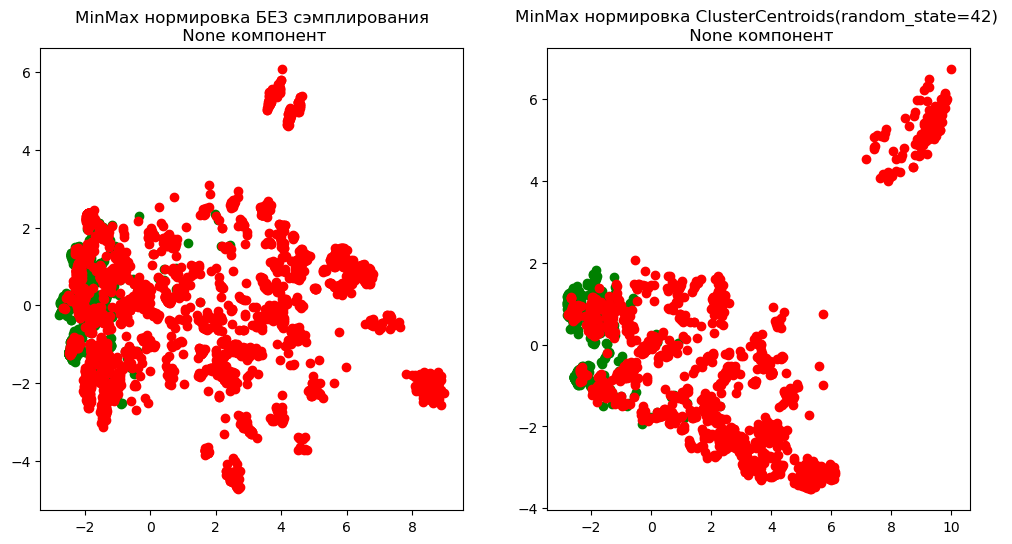

In [15]:
%%time

# with using default n_components(2) and default reduction transformer(PCA)
cluster_centroids, clusterCentroids_X, clusterCentroids_y, clusterCentroids_X_minmax, clusterCentroids_y_minmax = show_imbalanced_2d_plot(imbalance_obj=cluster_centroids, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [36]:
clusterCentroids_y_minmax.value_counts()

0    1650
1    1650
Name: obfuscated, dtype: int64

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 38min 38s
Wall time: 10min 8s


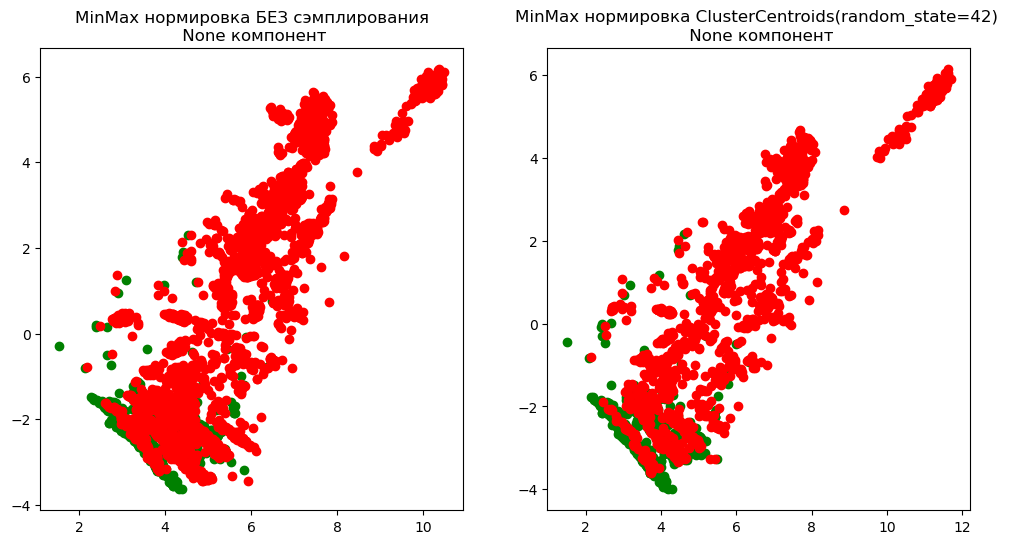

In [17]:
%%time

# with using default n_components(2) and TruncatedSVD(LSA) reduction transformer
show_imbalanced_2d_plot(imbalance_obj=cluster_centroids, X=X_compressed, Y=y_compressed, reduction_transformer=TruncatedSVD)
None

##### RandomUnderSampler method (fixed)

In [16]:
random_us = RandomUnderSampler(random_state=42)

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 3.45 s
Wall time: 1.72 s


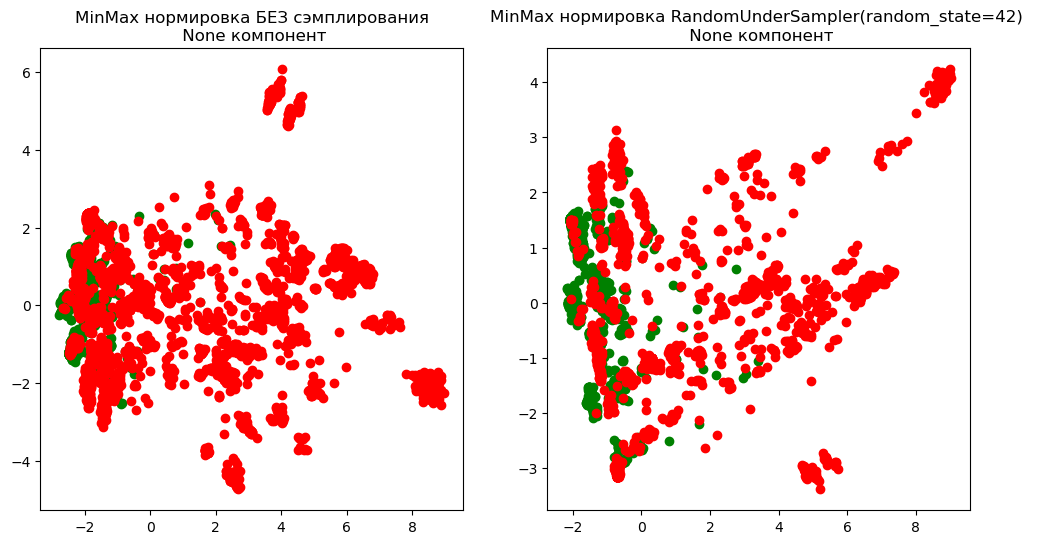

In [19]:
%%time 

# n_components = 2, dimension_transformer = PCA
random_us, randomUnderSampler_X, randomUnderSampler_y, randomUnderSampler_X_minmax, randomUnderSampler_y_minmax = show_imbalanced_2d_plot(imbalance_obj=random_us, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [37]:
randomUnderSampler_y_minmax.value_counts()

0    1650
1    1650
Name: obfuscated, dtype: int64

##### CondensedNearestNeighbour method (cleaning)

In [21]:
condensedNearestNeighbour = CondensedNearestNeighbour(random_state=42, n_jobs=-1)

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 31min 31s
Wall time: 8min 29s


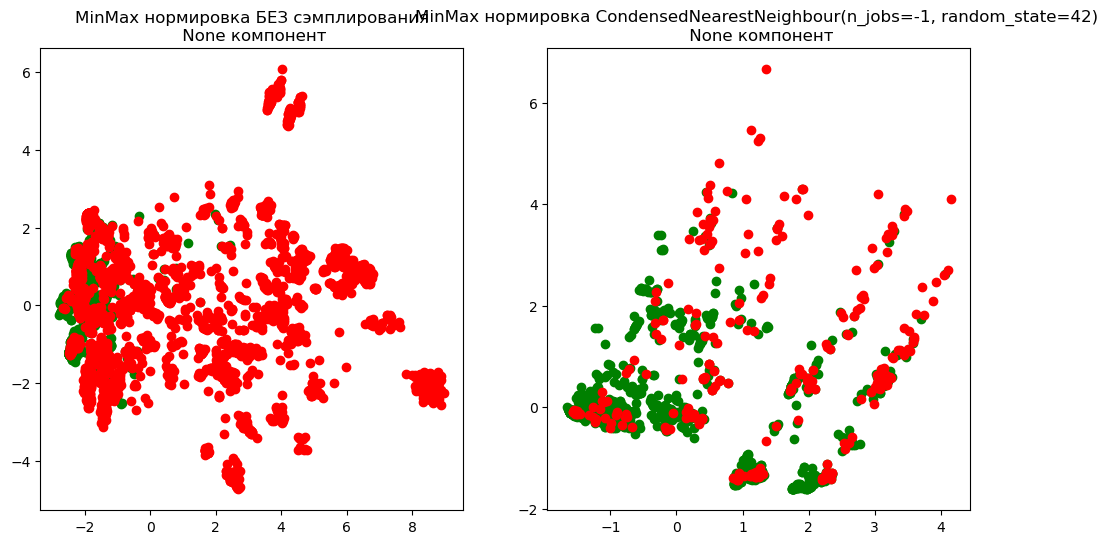

In [22]:
%%time 

# n_components = 2, dimension_transformer = PCA
condensedNearestNeighbour, condensedNearestNeighbour_X, condensedNearestNeighbour_y, condensedNearestNeighbour_X_minmax, condensedNearestNeighbour_y_minmax = show_imbalanced_2d_plot(imbalance_obj=condensedNearestNeighbour, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [38]:
condensedNearestNeighbour_y_minmax.value_counts()

0    1650
1     269
Name: obfuscated, dtype: int64

#####  TomekLinks method (cleaning)

In [23]:
tomekLinks = TomekLinks(n_jobs=-1)

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 27.6 s
Wall time: 8.8 s


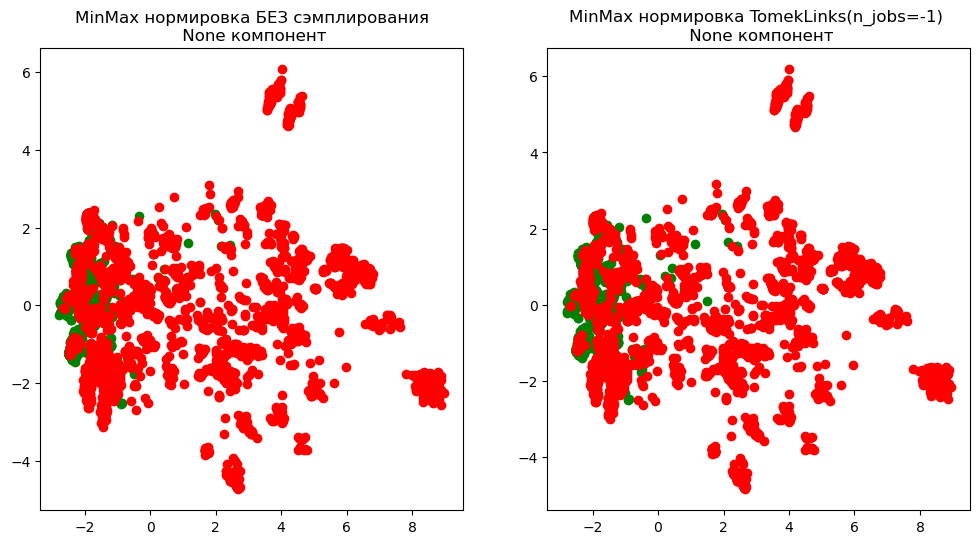

In [24]:
%%time 

# n_components = 2, dimension_transformer = PCA
tomekLinks, tomekLinks_X, tomekLinks_y, tomekLinks_X_minmax, tomekLinks_y_minmax = show_imbalanced_2d_plot(imbalance_obj=tomekLinks, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [39]:
tomekLinks_y_minmax.value_counts()

1    4852
0    1650
Name: obfuscated, dtype: int64

##### OneSidedSelection method (cleaning)

In [26]:
oneSidedSelection = OneSidedSelection(random_state=42, n_jobs=-1)

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 30.9 s
Wall time: 9.61 s


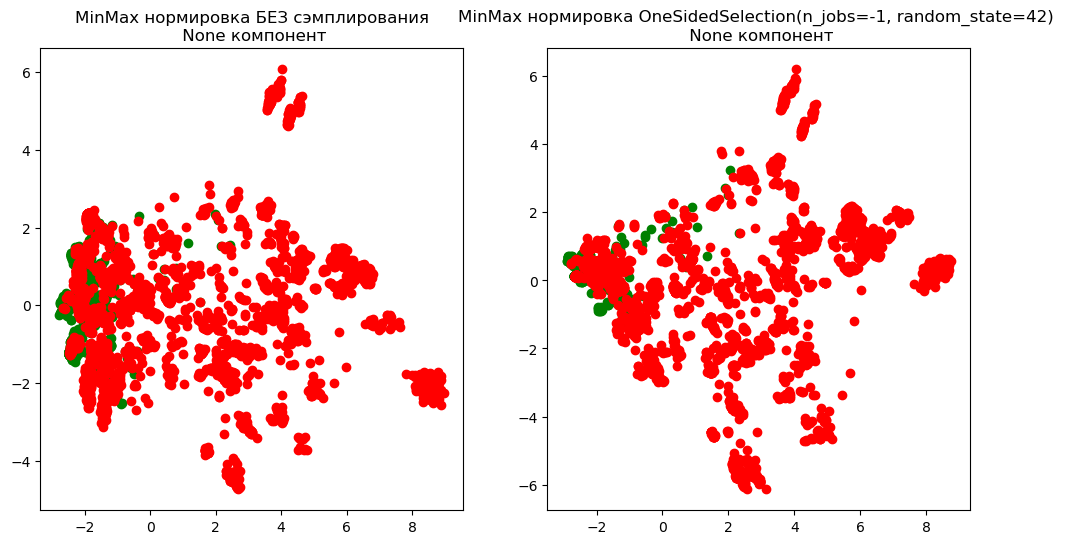

In [27]:
%%time 

# n_components = 2, dimension_transformer = PCA
oneSidedSelection, oneSidedSelection_X, oneSidedSelection_y, oneSidedSelection_X_minmax, oneSidedSelection_y_minmax = show_imbalanced_2d_plot(imbalance_obj=oneSidedSelection, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [40]:
oneSidedSelection_y_minmax.value_counts()

1    4527
0    1650
Name: obfuscated, dtype: int64

##### EditedNearestNeighbours (cleaning)

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 22.5 s
Wall time: 7.27 s


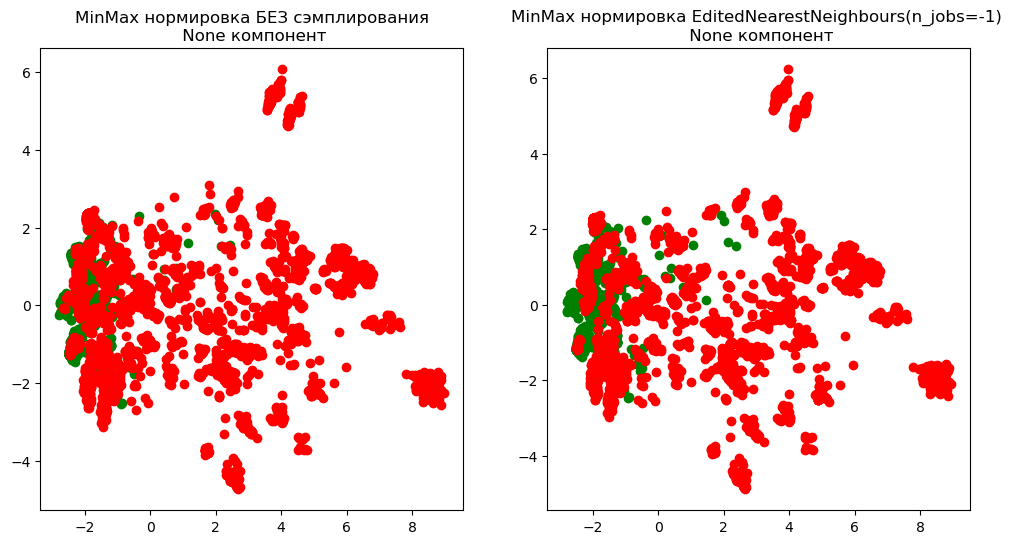

In [31]:
%%time 
editedNearestNeighbours_all = EditedNearestNeighbours(n_jobs=-1, kind_sel='all')

# n_components = 2, dimension_transformer = PCA
editedNearestNeighbours_all, editedNearestNeighbours_all_X, editedNearestNeighbours_all_y, editedNearestNeighbours_all_X_minmax, editedNearestNeighbours_all_y_minmax = show_imbalanced_2d_plot(imbalance_obj=editedNearestNeighbours_all, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [41]:
editedNearestNeighbours_all_y_minmax.value_counts()

1    4730
0    1650
Name: obfuscated, dtype: int64

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 23.2 s
Wall time: 7.64 s


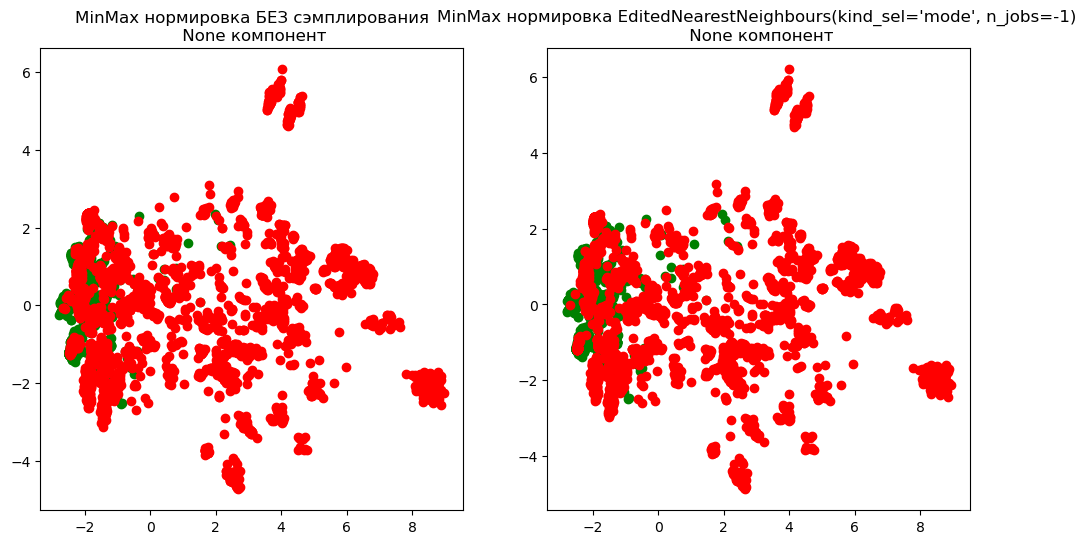

In [34]:
%%time 
editedNearestNeighbours_mode = EditedNearestNeighbours(n_jobs=-1, kind_sel='mode')

# n_components = 2, dimension_transformer = PCA
editedNearestNeighbours_mode, editedNearestNeighbours_mode_X, editedNearestNeighbours_mode_y, editedNearestNeighbours_mode_X_minmax, editedNearestNeighbours_mode_y_minmax = show_imbalanced_2d_plot(imbalance_obj=editedNearestNeighbours_mode, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [42]:
editedNearestNeighbours_mode_y_minmax.value_counts()

1    4836
0    1650
Name: obfuscated, dtype: int64

##### RepeatedEditedNearestNeighbours (cleaning)

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 1min 24s
Wall time: 24 s


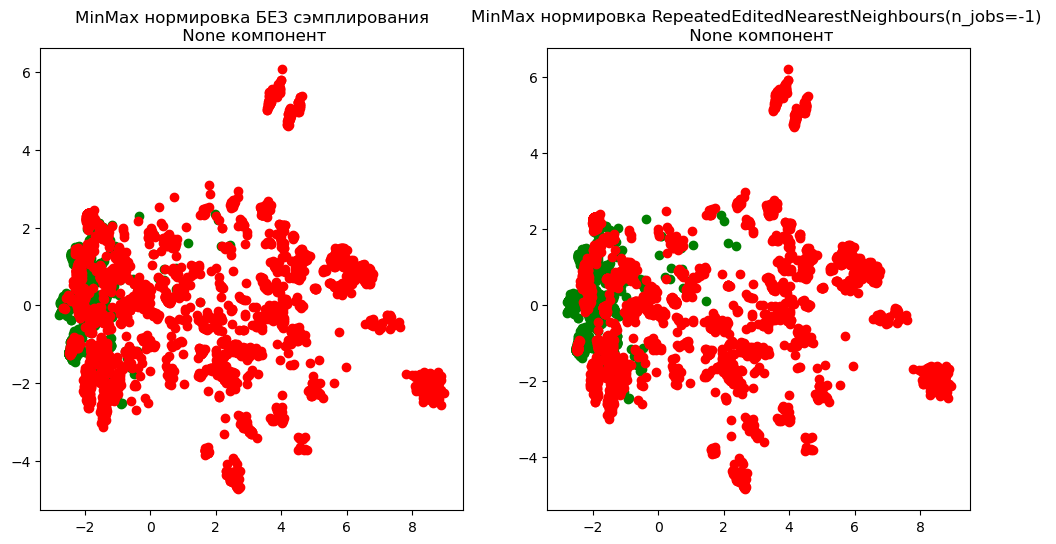

In [44]:
%%time
repeatedEditedNN_all = RepeatedEditedNearestNeighbours(kind_sel='all', n_jobs=-1)
# n_components = 2, dimension_transformer = PCA
repeatedEditedNN_all, repeatedEditedNN_all_X, repeatedEditedNN_all_y, repeatedEditedNN_all_X_minmax, repeatedEditedNN_all_y_minmax = show_imbalanced_2d_plot(imbalance_obj=repeatedEditedNN_all, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [46]:
repeatedEditedNN_all_y_minmax.value_counts()

1    4717
0    1650
Name: obfuscated, dtype: int64

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 1min 26s
Wall time: 25.3 s


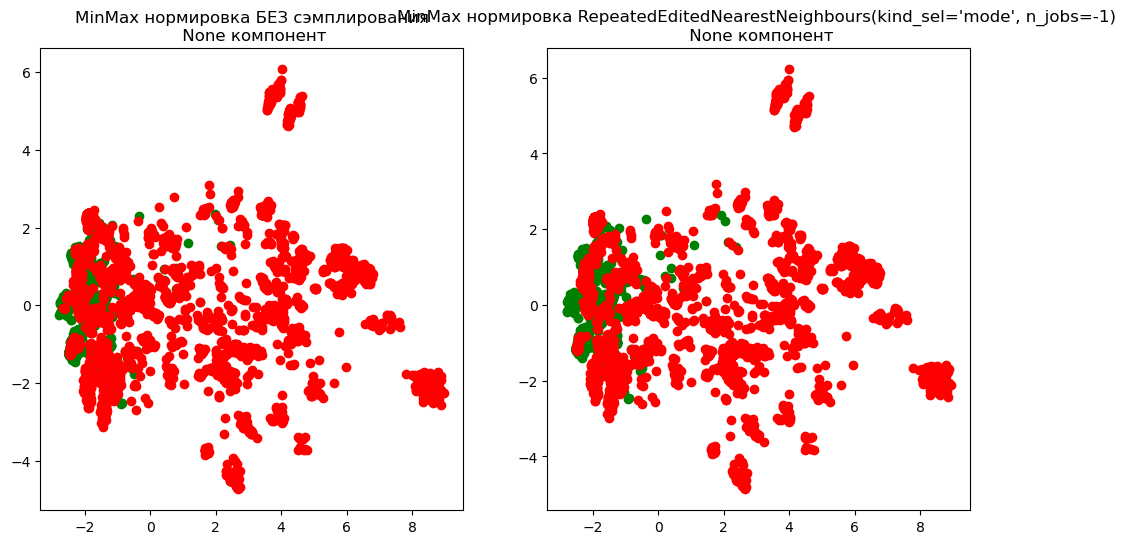

In [45]:
%%time
repeatedEditedNN_mode = RepeatedEditedNearestNeighbours(kind_sel='mode', n_jobs=-1)
# n_components = 2, dimension_transformer = PCA
repeatedEditedNN_mode, repeatedEditedNN_mode_X, repeatedEditedNN_mode_y, repeatedEditedNN_mode_X_minmax, repeatedEditedNN_mode_y_minmax = show_imbalanced_2d_plot(imbalance_obj=repeatedEditedNN_mode, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [47]:
repeatedEditedNN_mode_y_minmax.value_counts()

1    4807
0    1650
Name: obfuscated, dtype: int64

##### AllKNN (cleaning)

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 53.8 s
Wall time: 15.6 s


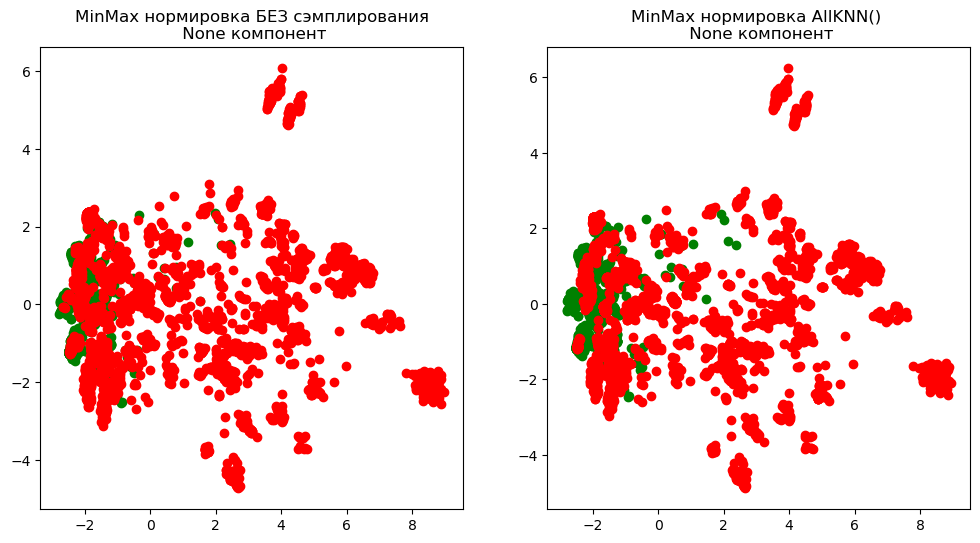

In [48]:
%%time
allKNN_all = AllKNN(kind_sel='all')
# n_components = 2, dimension_transformer = PCA
allKNN_all, allKNN_all_X, allKNN_all_y, allKNN_all_X_minmax, allKNN_all_y_minmax = show_imbalanced_2d_plot(imbalance_obj=allKNN_all, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [49]:
allKNN_all_y_minmax.value_counts()

1    4723
0    1650
Name: obfuscated, dtype: int64

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 55.5 s
Wall time: 16.8 s


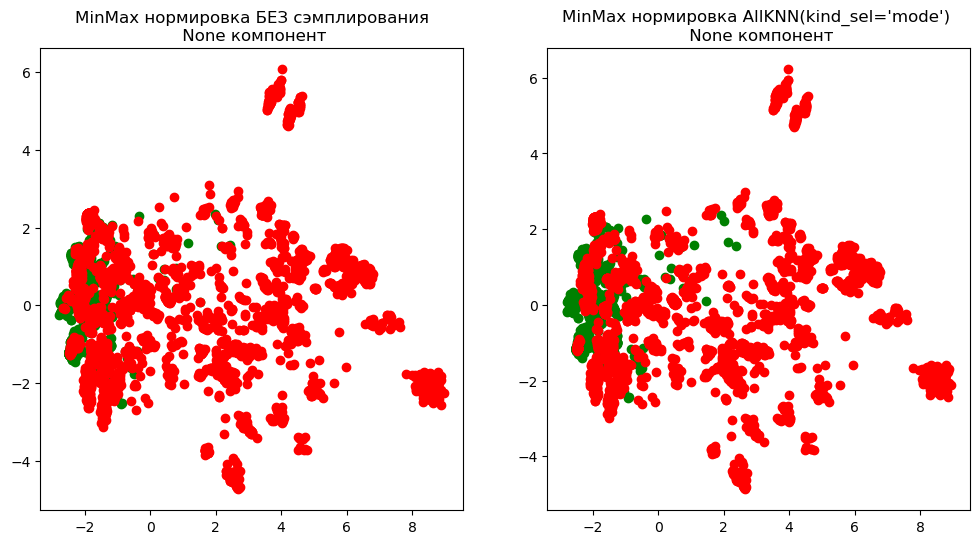

In [50]:
%%time
allKNN_mode = AllKNN(kind_sel='mode')
# n_components = 2, dimension_transformer = PCA
allKNN_mode, allKNN_mode_X, allKNN_mode_y, allKNN_mode_X_minmax, allKNN_mode_y_minmax = show_imbalanced_2d_plot(imbalance_obj=allKNN_mode, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [51]:
allKNN_mode_y_minmax.value_counts()

1    4739
0    1650
Name: obfuscated, dtype: int64

##### NeighbourhoodCleaningRule (cleaning)

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 31.6 s
Wall time: 16.3 s


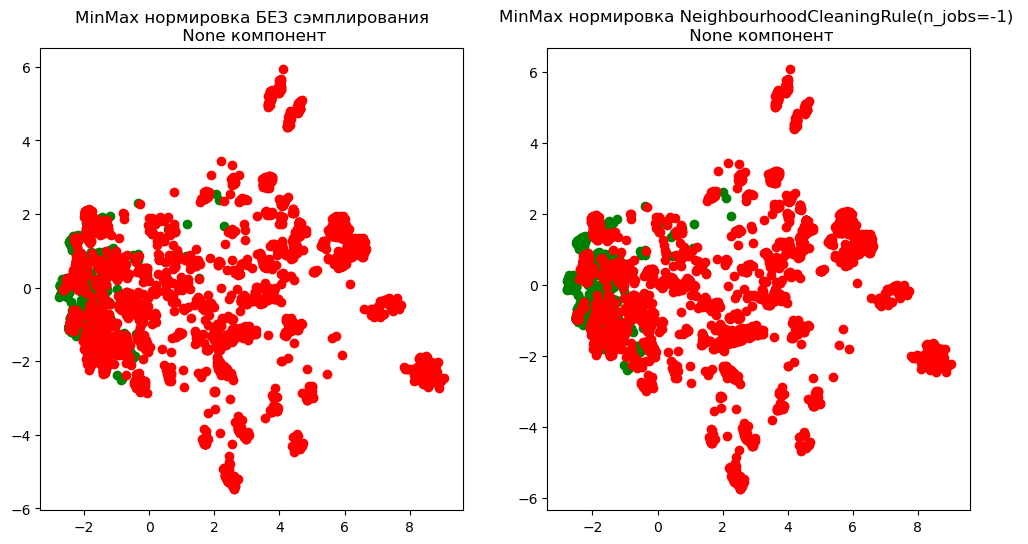

In [12]:
%%time
neighbourhoodCleaningRule_all = NeighbourhoodCleaningRule(n_jobs=-1, kind_sel='all')
# n_components = 2, dimension_transformer = PCA
neighbourhoodCleaningRule_all, neighbourhoodCleaningRule_all_X, neighbourhoodCleaningRule_all_y, neighbourhoodCleaningRule_all_X_minmax, neighbourhoodCleaningRule_all_y_minmax = show_imbalanced_2d_plot(imbalance_obj=neighbourhoodCleaningRule_all, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [13]:
neighbourhoodCleaningRule_all_y_minmax.value_counts()

1    4778
0    1650
Name: obfuscated, dtype: int64

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 30.9 s
Wall time: 10.1 s


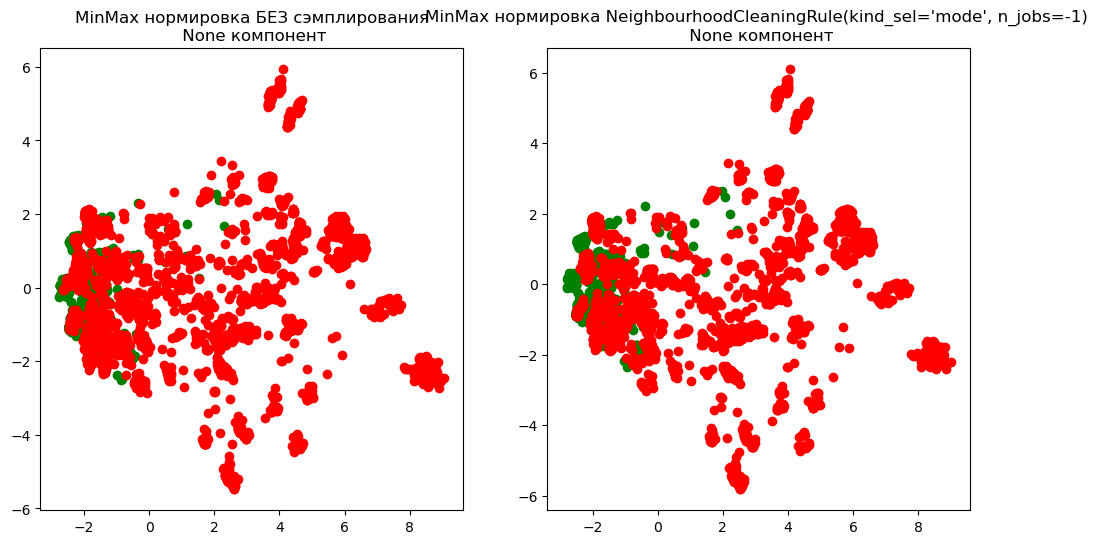

In [14]:
%%time
neighbourhoodCleaningRule_mode = NeighbourhoodCleaningRule(n_jobs=-1, kind_sel='mode')
# n_components = 2, dimension_transformer = PCA
neighbourhoodCleaningRule_mode, neighbourhoodCleaningRule_mode_X, neighbourhoodCleaningRule_mode_y, neighbourhoodCleaningRule_mode_X_minmax, neighbourhoodCleaningRule_mode_y_minmax = show_imbalanced_2d_plot(imbalance_obj=neighbourhoodCleaningRule_mode, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [15]:
neighbourhoodCleaningRule_mode_y_minmax.value_counts()

1    4716
0    1650
Name: obfuscated, dtype: int64

##### InstanceHardnessThreshold (fixed - при задании размера выборки + cleaning - при задании порога уверенности)

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
iht = InstanceHardnessThreshold(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    random_state=42,
    n_jobs=-1, 
    cv=3
)

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 5.23 s
Wall time: 32.4 s


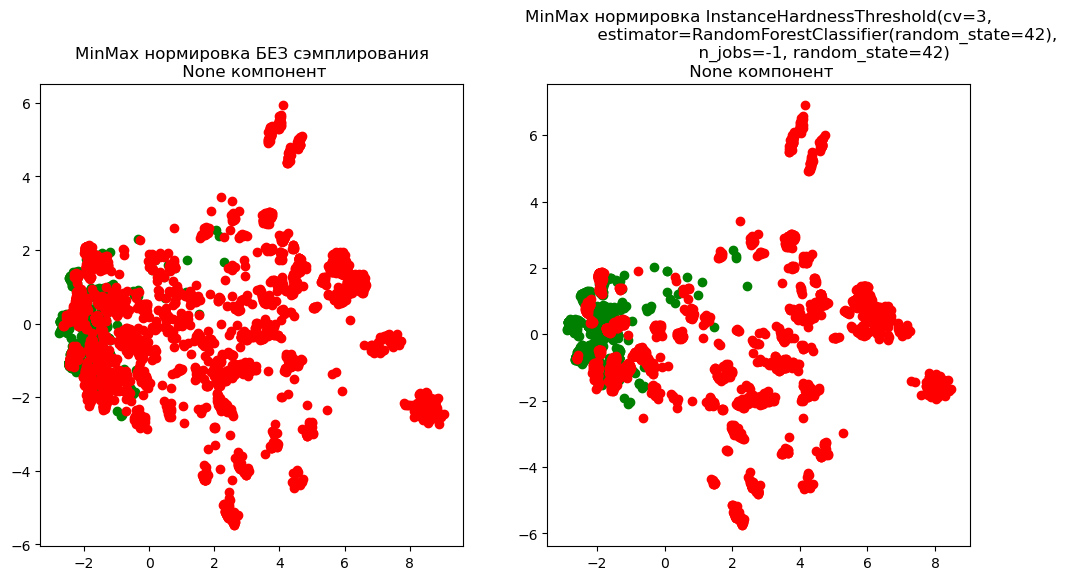

In [18]:
%%time
# n_components = 2, dimension_transformer = PCA
iht, iht_X, iht_y, iht_X_minmax, iht_y_minmax = show_imbalanced_2d_plot(imbalance_obj=iht, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [19]:
iht_y_minmax.value_counts()

1    3309
0    1650
Name: obfuscated, dtype: int64

##### NearMiss (fixed)

In [20]:
nearMiss = NearMiss(n_jobs=-1)

Default data's resample was completed successfully!
MinMax scaled data's resample was completed successfully!
CPU times: total: 9.14 s
Wall time: 3.93 s


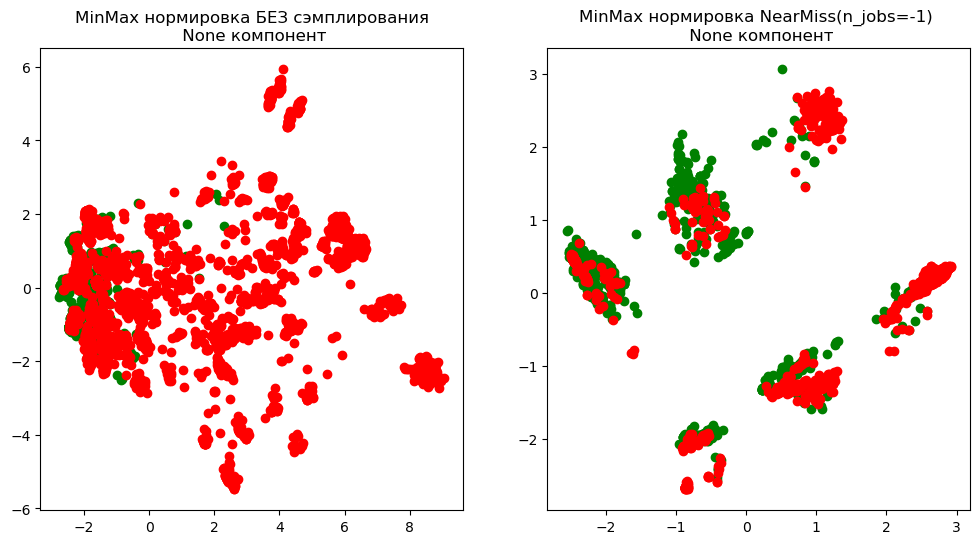

In [21]:
%%time
# n_components = 2, dimension_transformer = PCA
nearMiss, nearMiss_X, nearMiss_y, nearMiss_X_minmax, nearMiss_y_minmax = show_imbalanced_2d_plot(imbalance_obj=nearMiss, X=X_compressed, Y=y_compressed, reduction_transformer=PCA)

In [22]:
nearMiss_y.value_counts()

0    1650
1    1650
Name: obfuscated, dtype: int64